In [1]:
using JSON3
using JLD2
using CSV
using ComponentArrays
using DataFrames
using DftFunctionals
using Statistics
using AtomsIO
using Unitful
using UnitfulAtomic
using CairoMakie
using ColorSchemes
using Unitful
using UnitfulAtomic

# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
default_width = 9 * cm  # Column width

340.1574803149606

In [2]:
df_sol58lc = let
    csv_path = "../../sol58lc/Sol58LC.csv"
    df = DataFrame(CSV.File(csv_path))
    df = rename(df, "sysnames" => "name", " ref"=>"ref_Ang")
    df = transform(df, "ref_Ang" => ByRow(a -> austrip(a * u"Å")) => "ref_bohr")
    df[:, [:name, :ref_Ang, :ref_bohr]]
end

Row,name,ref_Ang,ref_bohr
,String15,Float64,Float64
1,Li_bcc,3.451,6.52144
2,Na_bcc,4.207,7.95008
3,K_bcc,5.211,9.84736
4,Rb_bcc,5.58,10.5447
5,Ca_fcc,5.555,10.4974
6,Sr_fcc,6.042,11.4177
7,Ba_bcc,5.004,9.45619
8,V_bcc,3.024,5.71453
9,Nb_bcc,3.293,6.22287


In [3]:
function build_dataframe(raw_data)
    keys = [:name, :a_opt,
            :dvol, :n_atoms, :kgrid, :occupation, :Ecut, :lattice, :damping_value, 
            :species, :eigenvalues, :symmetries_respect_rgrid, :occupation_threshold,
            :n_iter, :spin_polarization, :εF, :kweights, :smearing, :atomic_positions,
            :fft_size, :n_kpoints, :n_bands_converge, :kcoords_cart, :temperature,
            :variational, :use_symmetries_for_kpoint_reduction, :element_symbols,
            :history_Δρ, :runtime_ns, :n_bands, :kcoords, :converged, :energies,
            :symmetries_translations, :n_spin_components, :n_matvec, :τ, :recip_lattice,
            :model_name, :n_electrons, :n_dim, :atomic_positions_cart, :timedout,
            :symmetries_rotations, :algorithm, :history_Etot, :ρ, :scfres_extra_keys, :terms]
    cols = [key => [data[key] for data in raw_data] for key in keys]
    df = DataFrame(cols...)
    
    # Convert total SCF time from nanoseconds to seconds
    df = transform(df, :runtime_ns => (x -> x / 10^9) => :runtime_s)

    # Bring into original Sol58LC order
    df = leftjoin(df, df_sol58lc, on=:name)

    df
end

build_dataframe (generic function with 1 method)

In [4]:
files_before = filter(endswith(".json"), readdir("../pbe"; join=true))

58-element Vector{String}:
 "../pbe/eval_pbe_Ag_fcc.json"
 "../pbe/eval_pbe_AlAs_b3.json"
 "../pbe/eval_pbe_AlN_b3.json"
 "../pbe/eval_pbe_AlP_b3.json"
 "../pbe/eval_pbe_Al_fcc.json"
 "../pbe/eval_pbe_Au_fcc.json"
 "../pbe/eval_pbe_BAs_b3.json"
 "../pbe/eval_pbe_BN_b3.json"
 "../pbe/eval_pbe_BP_b3.json"
 "../pbe/eval_pbe_Ba_bcc.json"
 ⋮
 "../pbe/eval_pbe_Ta_bcc.json"
 "../pbe/eval_pbe_TiC_b1.json"
 "../pbe/eval_pbe_TiN_b1.json"
 "../pbe/eval_pbe_VC_b1.json"
 "../pbe/eval_pbe_VN_b1.json"
 "../pbe/eval_pbe_V_bcc.json"
 "../pbe/eval_pbe_W_bcc.json"
 "../pbe/eval_pbe_ZrC_b1.json"
 "../pbe/eval_pbe_ZrN_b1.json"

In [5]:
files_after = filter(endswith(".json"), readdir())

58-element Vector{String}:
 "Ag_fcc.json"
 "AlAs_b3.json"
 "AlN_b3.json"
 "AlP_b3.json"
 "Al_fcc.json"
 "Au_fcc.json"
 "BAs_b3.json"
 "BN_b3.json"
 "BP_b3.json"
 "Ba_bcc.json"
 ⋮
 "Ta_bcc.json"
 "TiC_b1.json"
 "TiN_b1.json"
 "VC_b1.json"
 "VN_b1.json"
 "V_bcc.json"
 "W_bcc.json"
 "ZrC_b1.json"
 "ZrN_b1.json"

In [6]:
df_before = build_dataframe(JSON3.read.(files_before));
df_after  = build_dataframe(JSON3.read.(files_after));

In [7]:
selected_keys =  [:name, :ref_bohr, :a_opt, :Ecut, :kgrid, :n_kpoints, :n_electrons, :n_iter, :runtime_s]
df_before_small = df_before[:, selected_keys]
df_after_small  = df_after[:, selected_keys]

df = innerjoin(
    df_before_small, df_after_small;
    on=[:name, :ref_bohr, :n_electrons, :Ecut, :kgrid, :n_kpoints],
    renamecols="_before"=>"_after"
)

Row,name,ref_bohr,a_opt_before,Ecut,kgrid,n_kpoints,n_electrons,n_iter_before,runtime_s_before,a_opt_after,n_iter_after,runtime_s_after
,String,Float64?,Float64,Int64,String,Int64,Int64,Int64,Float64,Float64,Int64,Float64
1,Li_bcc,6.52144,6.4946,37,"MonkhorstPack([18, 18, 18])",195,3,10,14.1902,6.42318,11,33.1954
2,Na_bcc,7.95008,7.9392,44,"MonkhorstPack([15, 15, 15])",120,9,16,42.0262,7.80026,17,96.6904
3,K_bcc,9.84736,9.98411,37,"MonkhorstPack([12, 12, 12])",72,9,14,37.5537,9.76404,14,90.3257
4,Rb_bcc,10.5447,10.7089,23,"MonkhorstPack([11, 11, 11])",56,9,15,23.1768,10.4416,14,50.5348
5,Ca_fcc,10.4974,10.4419,34,"MonkhorstPack([14, 14, 14])",104,10,15,63.6725,10.3054,13,94.3193
6,Sr_fcc,11.4177,11.3739,34,"MonkhorstPack([13, 13, 13])",84,10,14,29.7384,11.1968,13,68.4508
7,Ba_bcc,9.45619,9.50498,22,"MonkhorstPack([12, 12, 12])",72,10,13,20.6412,9.29915,12,31.0374
8,V_bcc,5.71453,5.66609,42,"MonkhorstPack([20, 20, 20])",256,13,17,31.1818,5.6305,17,65.4623
9,Nb_bcc,6.22287,6.25801,41,"MonkhorstPack([18, 18, 18])",195,13,14,32.6261,6.22754,13,67.8149


In [8]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,name,,Ag_fcc,,ZrN_b1,0,String
2,ref_bohr,8.32672,5.39328,8.18818,12.2379,0,"Union{Missing, Float64}"
3,a_opt_before,8.40841,5.20294,8.23342,12.5819,0,Float64
4,Ecut,38.931,18,41.5,49,0,Int64
5,kgrid,,"MonkhorstPack([11, 11, 11])",,"MonkhorstPack([21, 21, 21])",0,String
6,n_kpoints,178.207,56,183.5,506,0,Int64
7,n_electrons,14.8793,3,16.0,28,0,Int64
8,n_iter_before,16.7414,10,15.5,32,0,Int64
9,runtime_s_before,50.6237,7.03099,47.8972,121.99,0,Float64


In [9]:
(df.a_opt_before - df.a_opt_after) ./ df.a_opt_after

58-element Vector{Float64}:
 0.011118319711646394
 0.01781271086751742
 0.02253866096806749
 0.025599069467543586
 0.013240940460356652
 0.015816913226998377
 0.022135319718249013
 0.006321527355900698
 0.004893493225710543
 0.0048673668927397
 ⋮
 0.0013484635098151016
 0.0019274028843621826
 0.004905331653930197
 0.005918067729952561
 0.006797557215569651
 0.009416069534766655
 0.006562244655715948
 0.009163481955508482
 0.0011248427514150517

In [10]:
relative_err(x, y) = (x - y) / y

relative_err (generic function with 1 method)

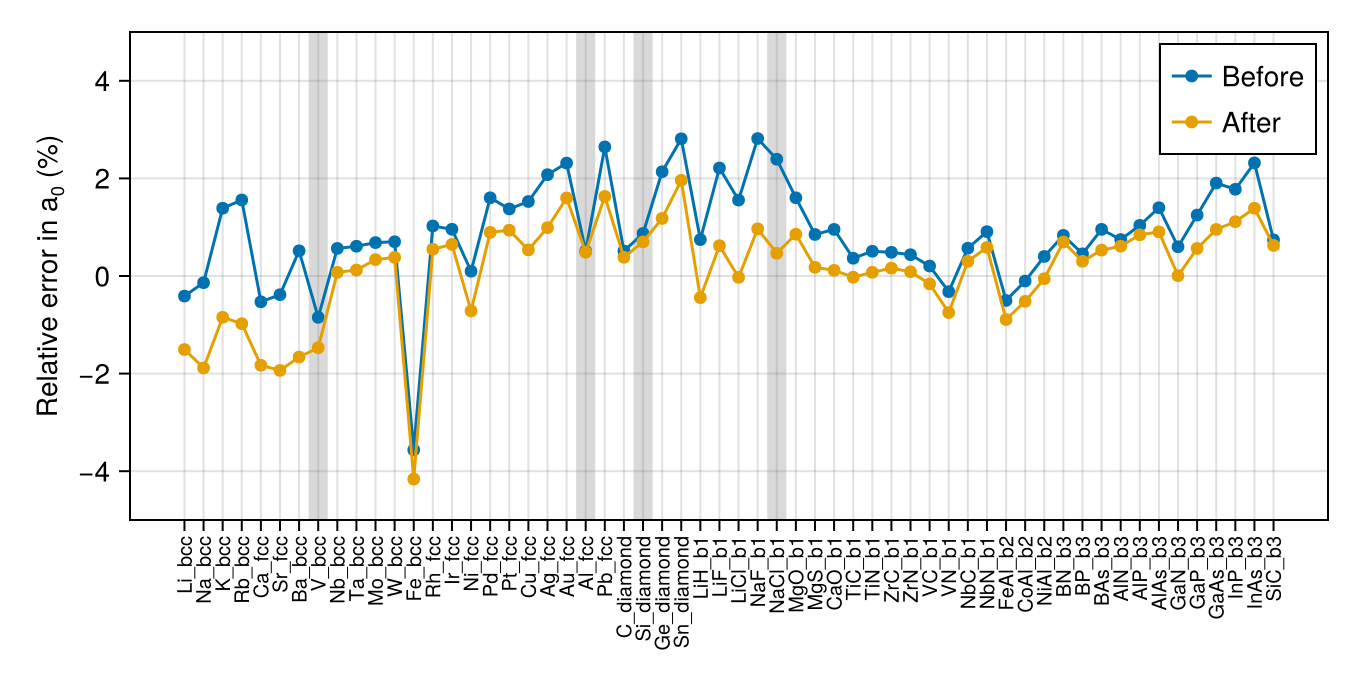

In [11]:
let 
    # Scale to percentages
    err_before = 100 * relative_err.(df.a_opt_before, df.ref_bohr)
    err_after  = 100 * relative_err.(df.a_opt_after,  df.ref_bohr)

    train_set = [
        "Si_diamond",
        "Al_fcc",
        "V_bcc",
        "NaCl_b1",
    ]

    xticks = (1:58, df.name)
    fig = Figure(size=(2default_width, default_width))
    ax = Makie.Axis(
        fig[1,1];
        ylabel=rich("Relative error in a", subscript("0"), " (%)"),
        yticks=-4:2:4, 
        xticks,
        xticklabelrotation=π/2,
        xticklabelsize=10,
    )
    h = 6
    ylims!(ax, (-5, 5))
    for i in 1:58
        if df.name[i] in train_set
            poly!(ax, [Rect(i - 0.5, -h, 1, 2h)], color=(:gray, 0.3))
        end
    end

    scatterlines!(ax, err_before, label="Before")
    scatterlines!(ax, err_after,  label="After")
    
    axislegend(ax, position=:rt)

    fig
end

## Exclude magnetic materials from eval (since we used no spin)

In [12]:
magnetic_set = [
    "Fe_bcc",
    "Ni_fcc",
    "Pd_fcc",
    "FeAl_b2",
]
df_small = filter(row -> !(row.name ∈ magnetic_set), df)

Row,name,ref_bohr,a_opt_before,Ecut,kgrid,n_kpoints,n_electrons,n_iter_before,runtime_s_before,a_opt_after,n_iter_after,runtime_s_after
,String,Float64?,Float64,Int64,String,Int64,Int64,Int64,Float64,Float64,Int64,Float64
1,Li_bcc,6.52144,6.4946,37,"MonkhorstPack([18, 18, 18])",195,3,10,14.1902,6.42318,11,33.1954
2,Na_bcc,7.95008,7.9392,44,"MonkhorstPack([15, 15, 15])",120,9,16,42.0262,7.80026,17,96.6904
3,K_bcc,9.84736,9.98411,37,"MonkhorstPack([12, 12, 12])",72,9,14,37.5537,9.76404,14,90.3257
4,Rb_bcc,10.5447,10.7089,23,"MonkhorstPack([11, 11, 11])",56,9,15,23.1768,10.4416,14,50.5348
5,Ca_fcc,10.4974,10.4419,34,"MonkhorstPack([14, 14, 14])",104,10,15,63.6725,10.3054,13,94.3193
6,Sr_fcc,11.4177,11.3739,34,"MonkhorstPack([13, 13, 13])",84,10,14,29.7384,11.1968,13,68.4508
7,Ba_bcc,9.45619,9.50498,22,"MonkhorstPack([12, 12, 12])",72,10,13,20.6412,9.29915,12,31.0374
8,V_bcc,5.71453,5.66609,42,"MonkhorstPack([20, 20, 20])",256,13,17,31.1818,5.6305,17,65.4623
9,Nb_bcc,6.22287,6.25801,41,"MonkhorstPack([18, 18, 18])",195,13,14,32.6261,6.22754,13,67.8149


## Combine with loss-landscape figure from gridsearch

In [13]:
pbe_x_f(s, θ) = 1 + θ.κ - θ.κ^2 / (θ.κ + θ.μ * s^2)

pbe_x_f (generic function with 1 method)

In [14]:
pbe_variants = [
    :gga_x_pbe,
    :gga_x_pbe_r,
    :gga_x_xpbe,
    :gga_x_pbe_sol,
    :gga_x_apbe,
    :gga_x_pbe_mol,
    :gga_x_pbefe,
]
params = Dict(
    key=>parameters(DftFunctional(key)) for key in pbe_variants
)

Dict{Symbol, ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(κ = 1, μ = 2)}}}} with 7 entries:
  :gga_x_apbe    => (κ = 0.804, μ = 0.26)
  :gga_x_xpbe    => (κ = 0.91954, μ = 0.23214)
  :gga_x_pbe     => (κ = 0.804, μ = 0.219515)
  :gga_x_pbefe   => (κ = 0.437, μ = 0.346)
  :gga_x_pbe_r   => (κ = 1.245, μ = 0.219515)
  :gga_x_pbe_sol => (κ = 0.804, μ = 0.123457)
  :gga_x_pbe_mol => (κ = 0.804, μ = 0.27583)

In [15]:
# Load grid-search results
datadir = joinpath(@__DIR__, "../../train/pbe_Si_Al_V_NaCl_gridsearch")
runs = [
    # "grid_search_results_20250512_154139",
    # "grid_search_results_20250513_144244",
    # "grid_search_results_20250513_144351",
    # "grid_search_results_20250514_095948",
    # "grid_search_results_20250514_111830",
    "grid_search_results_20250515_145905",
    "grid_search_results_20250516_111755",
    "grid_search_results_20250516_111848",
]
files = reduce(vcat, [readdir(joinpath(datadir, x); join=true) for x in runs])
files = filter(endswith(".json"), files)
df = DataFrame()
for f in files
    data = only(JSON3.read(f))
    if haskey(data, "loss")
        push!(df, (; theta=Vector{Float64}(data["theta"]), loss=data["loss"], preds=Dict{Symbol,Float64}(data["preds"])))
    end
end
df

Row,theta,loss,preds
,Array…,Float64,Dict…
1,"[0.1, 0.1]",0.000737347,"Dict(:NaCl=>10.1228, :Al=>7.54429, :V=>5.49443, :Si=>10.1986)"
2,"[0.1, 0.2]",0.000801281,"Dict(:NaCl=>10.0929, :Al=>7.5845, :V=>5.48781, :Si=>10.2174)"
3,"[0.1, 0.3]",0.000900357,"Dict(:NaCl=>10.0631, :Al=>7.62474, :V=>5.47731, :Si=>10.2231)"
4,"[0.1, 0.4]",0.00100133,"Dict(:NaCl=>10.038, :Al=>7.65333, :V=>5.46727, :Si=>10.2232)"
5,"[0.1, 0.5]",0.00109705,"Dict(:NaCl=>10.0171, :Al=>7.67628, :V=>5.45813, :Si=>10.2205)"
6,"[0.1, 0.6]",0.00118596,"Dict(:NaCl=>9.99938, :Al=>7.69524, :V=>5.44992, :Si=>10.2163)"
7,"[0.1, 0.7]",0.00126692,"Dict(:NaCl=>9.98422, :Al=>7.71059, :V=>5.44265, :Si=>10.2113)"
8,"[0.1, 0.8]",0.00134028,"Dict(:NaCl=>9.97105, :Al=>7.72283, :V=>5.43615, :Si=>10.206)"
9,"[0.1, 0.9]",0.00140666,"Dict(:NaCl=>9.95947, :Al=>7.73243, :V=>5.43025, :Si=>10.2006)"


In [16]:
# Load training trajectory
df_traj = let 
    file = joinpath(datadir, "../pbe_Si_Al_V_NaCl/trajectory_combined.json")
    traj = JSON3.read(file)
    df = DataFrame() 
    for state in traj
        if haskey(state, "loss")
            push!(df, (; theta=Vector{Float64}(state["theta"]), loss=state["loss"], preds=Dict{Symbol,Float64}(state["preds"])))
        end
    end
    df
end

Row,theta,loss,preds
,Array…,Float64,Dict…
1,"[0.804, 0.219515]",0.000186576,"Dict(:NaCl=>10.7679, :Al=>7.6336, :V=>5.66609, :Si=>10.3354)"
2,"[0.803315, 0.218283]",0.000184584,"Dict(:NaCl=>10.7662, :Al=>7.63263, :V=>5.66522, :Si=>10.3344)"
3,"[0.803315, 0.218283]",0.000184584,"Dict(:NaCl=>10.7662, :Al=>7.63263, :V=>5.66522, :Si=>10.3344)"
4,"[0.743829, 0.111111]",0.000150801,"Dict(:NaCl=>10.5468, :Al=>7.55895, :V=>5.5778, :Si=>10.2448)"
5,"[0.743829, 0.111111]",0.000150801,"Dict(:NaCl=>10.5468, :Al=>7.55895, :V=>5.5778, :Si=>10.2448)"
6,"[0.774548, 0.167255]",0.000127078,"Dict(:NaCl=>10.6829, :Al=>7.59399, :V=>5.62665, :Si=>10.293)"
7,"[0.774548, 0.167255]",0.000127078,"Dict(:NaCl=>10.6829, :Al=>7.59399, :V=>5.62665, :Si=>10.293)"
8,"[0.766833, 0.153699]",0.000121987,"Dict(:NaCl=>10.6551, :Al=>7.58495, :V=>5.61554, :Si=>10.2816)"
9,"[0.766833, 0.153699]",0.000121987,"Dict(:NaCl=>10.6551, :Al=>7.58495, :V=>5.61554, :Si=>10.2816)"


In [17]:
# Add point at (0., 0.) which recovers LDA exchange (identical to the others with κ=0)
# We use the value from (0.0, 0.1)
κ_complete = [getindex.(df.theta, 1); 0.]
μ_complete = [getindex.(df.theta, 2); 0.]
l = df.loss[findfirst(isequal([0.0, 0.1]), df.theta)]
loss_complete = [df.loss; l]

121-element Vector{Float64}:
 0.0007373474323896208
 0.0008012812259880988
 0.0009003568946459599
 0.0010013327459217276
 0.0010970504307339759
 0.0011859601067056454
 0.0012669198197062144
 0.0013402759991904965
 0.00140665758357007
 0.0014666417928975157
 ⋮
 0.001171302820277271
 0.0011713029786317246
 0.0011713004834614097
 0.0011713028729353444
 0.0011713027727766974
 0.0011713029178696496
 0.0011713027729506266
 0.001171302582404068
 0.0011713028296992832

Full MARE (%)
mean(abs, err_before) = 1.0839669530188072
mean(abs, err_after) = 0.7325293460605593
Full RMSRE (%)
sqrt(mean(abs2, err_before)) = 1.3069810199127727
sqrt(mean(abs2, err_after)) = 0.91651329241623


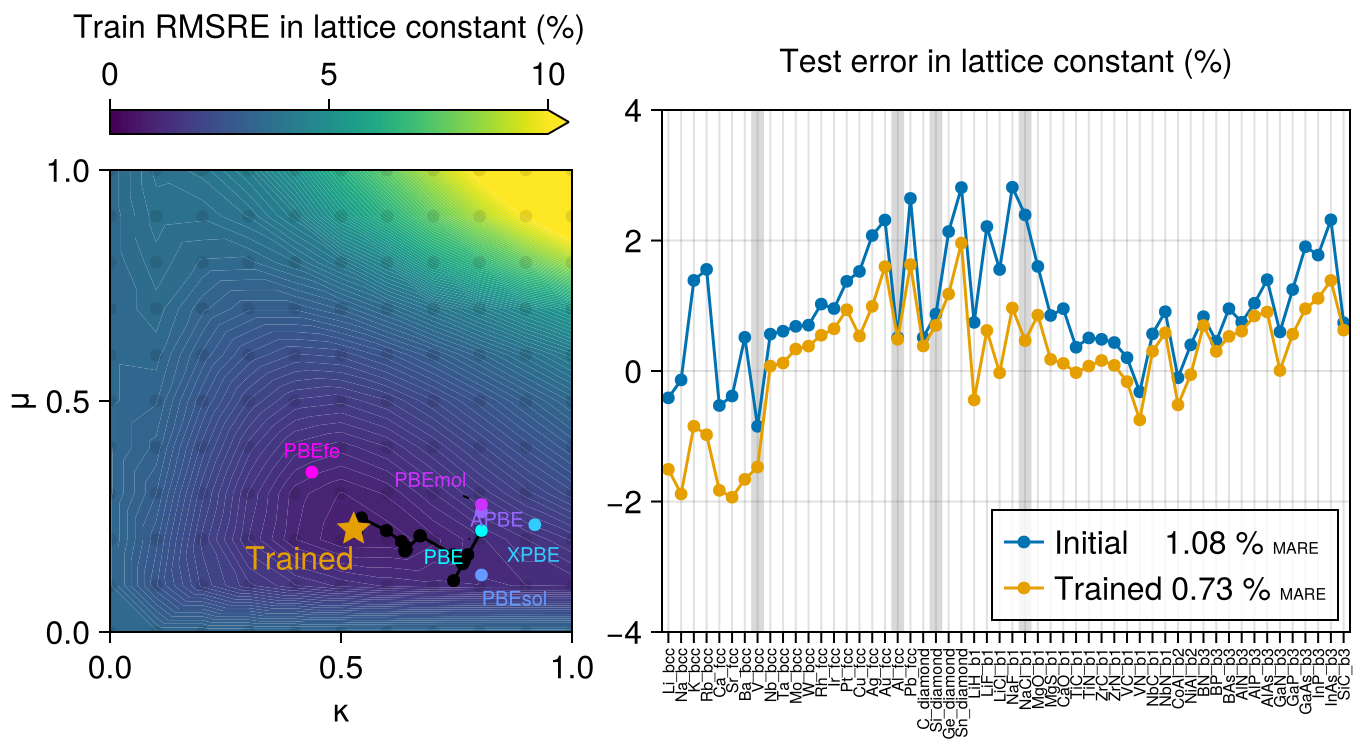

In [18]:
let 
    #fig = Figure(size=(1000,500))
    fig = Figure(
        size=(2 * default_width, 1.1 * default_width),
        fontsize=12pt,
        figure_padding=(0,5,5,5),
    )

    #======================#
    colors = Makie.wong_colors()
    ax = Makie.Axis(
        fig[1,1],
        alignmode = Inside(), 
        xlabel="κ",
        ylabel="μ",
    )
    ax.tellwidth = true
    theta = df_traj.theta

    co = tricontourf!(ax, κ_complete, μ_complete, 100sqrt.(loss_complete), levels=0:0.1:10, extendhigh=:auto)
    scatter!(ax, κ_complete, μ_complete, color=:black, alpha=0.1)

    cb = Colorbar(fig[0,1], co, label="Train RMSRE in lattice constant (%)", vertical=false)
    # cb = Colorbar(fig[0:1,1,Top()], co, vertical=false)
    # Label(fig[0:1,1,Top()], "Train RMSRE in lattice constant (%)")

    # Plot trajectory & final state
    scatterlines!(ax, getindex.(theta, 1), getindex.(theta, 2), color=:black)

    # Plot other PBE variants from the literature
    pbe_variants = [
        ("PBE",    :gga_x_pbe    ),
        # ("revPBE", :gga_x_pbe_r),
        ("XPBE",   :gga_x_xpbe   ),
        ("PBEsol", :gga_x_pbe_sol),
        ("APBE",   :gga_x_apbe   ),
        ("PBEmol", :gga_x_pbe_mol),
        ("PBEfe",  :gga_x_pbefe  ),
    ]
    colormap = resample(ColorSchemes.cool, length(pbe_variants))
    for (i, (label, key)) in enumerate(pbe_variants)
        θ = params[key]
        scatter!(ax, [θ.κ], [θ.μ]; color=colormap[i], label)
    end

    scatter!(ax, [theta[end][1]], [theta[end][2]], color=colors[2], marker=:star5, markersize=20, label="Trained")
    limits!(ax, (0., 1), (0., 1))

    points = map(pbe_variants) do (_, key)
        θ = params[key]
        (θ.κ, θ.μ)
    end
    annotation!(ax, points, text=[label for (label, _) in pbe_variants],
                fontsize=10, 
                textcolor=collect(colormap)
    )
    annotation!(ax, [theta[end][1]], [theta[end][2]], text="Trained",
                align=(:right, :top),
                textcolor=colors[2])


    # axislegend(ax, position=:lt)
    # Legend(fig[2,1], ax, orientation=:horizontal, nbanks=3)

    #==============================#
    # Scale to percentages
    err_before = 100 * relative_err.(df_small.a_opt_before, df_small.ref_bohr)
    err_after  = 100 * relative_err.(df_small.a_opt_after,  df_small.ref_bohr)

    train_set = [
        "Si_diamond",
        "Al_fcc",
        "V_bcc",
        "NaCl_b1",
    ]
    xticks = (1:size(df_small, 1), df_small.name)
    ax = Makie.Axis(
        fig[0:1,2:3];
        # ylabel="Error in lattice constant (%)",
        yticks=-4:2:4, 
        xticks,
        xticklabelrotation=π/2,
        xticklabelsize=8,
    )
    h = 6
    xlims!(ax, (0.5, xticks[1][end] + 0.5))
    ylims!(ax, (-4, 4))
    for i in 1:size(df_small, 1)
        if df_small.name[i] in train_set
            poly!(ax, [Rect(i - 0.5, -h, 1, 2h)], color=(:gray, 0.3))
        end
    end
    scatterlines!(ax, err_before, label=rich("Initial    1.08 % ", rich("MARE", fontsize=8)))
    scatterlines!(ax, err_after,  label=rich("Trained 0.73 % ", rich("MARE", fontsize=8)))
    axislegend(ax, position=:rb, backgroundcolor=(:white,0.8))

    Label(fig[0:1,2:3,Top()], "Test error in lattice constant (%)")

    println("Full MARE (%)")
    @show mean(abs, err_before)
    @show mean(abs, err_after)
    println("Full RMSRE (%)")
    @show sqrt(mean(abs2, err_before))
    @show sqrt(mean(abs2, err_after))

    colsize!(fig.layout, 1, Aspect(1, 1))
    # resize_to_layout!(fig)

    save("xc_finetuning.pdf", fig)

    fig
end

In [19]:
0.91651329241623 / 1.3069810199127727

0.7012445310624309